In [21]:
# 1. Взять датасет из домашнего задания №2. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.optimize import Bounds
from scipy.optimize import minimize

df_marketing = pd.read_csv('marketing_campaign.csv', header = 0, sep = ',')
df_subscribers = pd.read_csv('subscribers.csv', header = 0, sep = ',')
df_users = pd.read_csv('users.csv', header = 0, sep = ',')
df = df_marketing.merge(df_subscribers, on='user_id', how='inner').merge(df_users, on='user_id', how='inner')
df.head()

,user_id,date_served,marketing_channel,variant,language_displayed,converted,subscribing_channel,date_subscribed,date_canceled,is_retained,age_group,language_preferred
0,a1000,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,0-18 years,English
1,a1001,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,19-24 years,English
2,a1002,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,24-30 years,English
3,a1003,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,30-36 years,English
4,a1004,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,36-45 years,English


In [22]:
# создаем таблицу сопряженности на основе результатов A/B-теста
data1 = df.groupby('variant')['converted'].value_counts().unstack()
data1.head()

converted,False,True
variant,,
control,4705,371
personalization,4241,705


In [23]:
result = stats.chi2_contingency(data1, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 126.07767827548582, pvalue = 2.9568009705199523e-29


В personalization конверсия выше. Статичтически значимо.

In [24]:
# 2. Цех может производить стулья и столы. На производство стула идет 5 единиц материала, на производство стола - 20 единиц (футов красного дерева).
# Стул требует 10 человеко-часов, стол - 15. Имеется 400 единиц материала и 450 человеко-часов. 
# Прибыль при производстве стула - 45 долларов США, при производстве стола - 80 долларов США. 
# Сколько надо сделать стульев и столов, чтобы получить максимальную прибыль?

def value(x):
  return -45*x[0] - 80*x[1]

neq_cons = {'type': 'ineq',
             'fun': lambda x: np.array ([400 - 5*x[0] - 20*x[1],
                                         450 - 10*x[0] - 15*x[1]])}

bnds = Bounds([0, 0], [np.inf, np.inf])

x0 = np.array([10, 10])
res = minimize(value, x0, method='SLSQP', constraints=neq_cons, bounds=bnds)
print(res.x)

[24. 14.]


Стульев - 24 шт
Столов - 14 шт

In [25]:
# 3. Средний накопленный доход на пользователя с сайта (cumulative ARPU) составил: day1 0.4$, day3 0.6$, day7 0.8$, day14 1.10$ , day21 1.30$, day30 1.40$.
# Подберите аппроксимирующую кривую и сделайте прогноз, сколько в среднем принесет денег пользователь на 90й день. Обоснуйте выбор одной из аппроксимирующей кривой вида: y = a*b^x или y = a*ln(x) + b. 

df = pd.DataFrame({'day': [1,3,7,14,21,30],
                   'retained': [0.4,0.6,0.8,1.10,1.30,1.40]})
df.head(6)

,day,retained
0,1,0.4
1,3,0.6
2,7,0.8
3,14,1.1
4,21,1.3
5,30,1.4


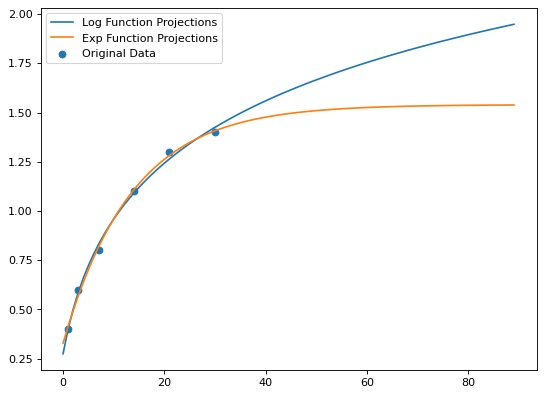

In [26]:
# задаем аппроксимирующую логарифмияескую функцию
def log_func( x, a, b, c ):
    return -a * np.log2( b + x ) + c

# задаем аппроксимирующую экспоненциальную функцию
def exp_func( x, a, b, c ):
    return a * np.exp( -b * x ) + c

# подбираем оптимальные параметры логарифмияеской функции
from scipy.optimize import curve_fit
log_popt, log_pcov = curve_fit(log_func, df['day'], df['retained'])

# подбираем оптимальные параметры экспоненциальной функции
exp_popt, exp_pcov = curve_fit(exp_func, df['day'], df['retained'])

# задаем точку прогноза - сколько денег будет на 90й день
projection_endpoint = 90

# задаем значения функции x с помощью метода np.arange и параметры подобранной кривой
log_y_projected = log_func( np.arange( projection_endpoint ), *log_popt )
exp_y_projected = exp_func( np.arange( projection_endpoint ), *exp_popt )

# смотрим график исходных данных и полученных кривых
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df['day'], df['retained'], label="Original Data" )
plt.plot( log_y_projected, label="Log Function Projections" )
plt.plot( exp_y_projected, label="Exp Function Projections" )
plt.legend()
plt.show()

In [27]:
# делаем прогноз удержанных пользователей сайта на 90й день
print('Прогноз кол-ва денег через 90 дней по log модели', round(log_y_projected[89],0))
print('Прогноз кол-ва денег через 90 дней по exp модели', round(exp_y_projected[89],0))

Прогноз кол-ва денег через 90 дней по log модели 2.0
Прогноз кол-ва денег через 90 дней по exp модели 2.0
